Make a Latin Hypercube of training points, then call CLASS + CLPT to make the y points for it. 

In [1]:
from subprocess import call
from time import time
from itertools import izip
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from collections import OrderedDict
from classy import Class

In [2]:
np.random.seed(0)
def make_LHC(ordered_params, N):
    """
    Return a vector of points in parameter space that defines a latin hypercube.
    :param ordered_params:
        OrderedDict that defines the ordering, name, and ranges of parameters
        used in the trianing data. Keys are the names, value of a tuple of (lower, higher) bounds
    :param N:
        Number of points per dimension in the hypercube. Default is 500.
    :return
        A latin hyper cube sample in HOD space in a numpy array.
    """
    np.random.seed(int(time()))

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T

In [3]:
default_params = {
        'output': 'mPk',
        'ln10^{10}A_s': np.log( (10**10)*2.42e-9),
        'P_k_max_h/Mpc': 100.0,
        'n_s': 0.96,
        'h': 0.7,
        #'non linear': 'halofit',
        'omega_b': 0.022,
        'omega_cdm': 0.1122,
        'z_pk': 0.0}

def compute_pk(input_params, outputdir):
    """
    Use class to compute the power spectrum as initial conditions for the sims.
    :param input_params:
        Updates to the default parameters for CLASS. 
    :param outputdir:
        Outputdir to store the power specturm. It should be the same as where picola is loaded from.
    :return:
        None
    """

    params = default_params.copy()
    
    #params.update(input_params)

    cosmo = Class()
    cosmo.set(params)

    cosmo.compute()#level = ["initnonlinear"])

    k_size = 600
    ks = np.logspace(-3, 1.5, k_size).reshape(k_size,1,1)
    zs = np.array([params['z_pk']])

    pks =  cosmo.get_pk(ks, zs, k_size, 1, 1)[:,0,0]

    np.savetxt(os.path.join(outputdir, 'class_pk.dat'), np.c_[ks[:,0,0], pks],\
               delimiter = ' ')

    #return cosmo.sigma8()



Possibly CLEFT_GSM as well?

In [4]:
clpt_config = """CORR_FUNC

Init
r_max           130
r_min           1
r_bin_num       80
n_thread        2
xi_file         {outputdir}/xi.txt
pow_spec_file   {outputdir}/class_pk.dat
"""

def write_clpt_params(input_params, outputdir):
    """
    Use class to compute the power spectrum as initial conditions for the sims.
    :param input_params:
        Updates to the default parameters for CLASS. 
    :param outputdir:
        Outputdir to store the power specturm. It should be the same as where picola is loaded from.
    :param jobname:
        What to name the submitted jobs
    :return:
        None
    """
    fname = os.path.join(outputdir, 'par.txt')

    #params = default_params.deepcopy()
    #params.update(input_params)
    
    
    formatted_config = clpt_config.format(outputdir=outputdir)

    with open(fname, 'w') as f:
        f.write(formatted_config)


In [5]:
def make_kils_command(jobname, max_time, outputdir, queue='short'):  # 'bulletmpi'):
    '''
    Return a list of strings that comprise a bash command to call trainingHelper.py on the cluster.
    Designed to work on ki-ls's batch system
    :param jobname:
        Name of the job. Will also be used to make the parameter file and log file.
    :param max_time:
        Time for the job to run, in hours.
    :param outputdir:
        Directory to store output and param files.
    :param queue:
        Optional. Which queue to submit the job to.
    :return:
        Command, a list of strings that can be ' '.join'd to form a bash command.
    '''
    log_file = jobname + '.out'
    param_file = jobname + '.npy'
    command = ['bsub',
               '-q', queue,
               '-n', str(8),
               '-J', jobname,
               '-oo', os.path.join(outputdir, log_file),
               '-W', '%d:00' % max_time,
               '/u/ki/swmclau2/Git/CLPT_GSRSD/CLPT/clpt.exe %s'%(os.path.join(outputdir, 'par.txt'))]

    return command


In [6]:
#10x planck 2018 contours
ordered_params = OrderedDict({'omega_b':[0.02233-0.00075,0.02233+0.00075 ],
                  'omega_cdm':[0.1198-0.012/2, 0.1198+0.012/2],
                  'ln10^{10}A_s':[3.043-0.14/2, 3.043+0.14/2],
                  'n_s': [0.96605-0.042/2, 0.96605+0.042/2],
                  'h': [67.37 - 5.4/2, 67.37+5.4/2]})

In [7]:
lhc = make_LHC(ordered_params, 500)

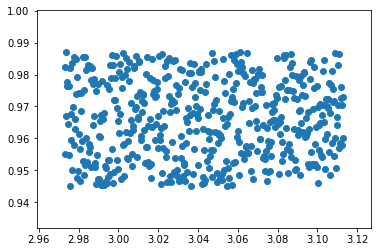

In [8]:
plt.scatter(lhc[:,2], lhc[:,3])

In [9]:
output_dir = './data'

In [10]:
%%bash
ls ./data/point_000/*
less ./data/point_000/albert_000.out

./data/point_000/albert_000.out
./data/point_000/class_pk.dat
./data/point_000/par.txt
./data/point_000/xi.txt
CORR_FUNC

Init
r_max               130
r_min               1
r_bin_num           80
n_thread            2
xi_file             ./data/point_000/xi.txt
pow_spec_file       ./data/point_000/class_pk.dat
Entry "k_input" not found; Using default value: none
Entry "q_input" not found; Using default value: none
Entry "k_output" not found; Using default value: ../data/k_func.txt
Entry "q_output" not found; Using default value: ../data/q_func.txt
Linear power spectrum loaded from: ./data/point_000/class_pk.dat
Generating Q_n ( 1 to 8 )... Done.
Generating R_n ( 1 to 2 )... Done.
Generating q-dependent functions: Done.
Entry "y_max" not found; Using default value: 50
Entry "y_bin_num" not found; Using default value: 100
Generating correlation... Correlation xi function obtained. 
Generating correlation... Pairwise velocity function obtained. 
Entry "v12_file" not found; Using default v

In [15]:
from glob import glob
from os import path
import h5py
def consolidate_outputs(directory, ordered_params, lhc,  fname= "xi.hdf5"):
    """
    Take outputs from compute_on_subet and write them to one hdf5 file.
    :param directory:
        The directory with the outputs in them
    """
    output_fnames = sorted(glob(path.join(directory, 'point_*/xi.txt') ) )

    all_output = []
    # i'd like to find a way to make the numpy arrays a priori but not sure how
    n_bins = 0 
    for o_fname in output_fnames:
        output = np.loadtxt(o_fname)
        all_output.append(output)
        n_bins = output.shape[0]

    all_output = np.array(all_output)
    f = h5py.File(path.join(directory, fname), 'w')

    try:

        f.attrs['param_names'] = ordered_params.keys()
        f.attrs['param_vals'] = lhc
        print all_output.shape
        f.attrs['scale_bins'] = all_output[0, :n_bins, 0] #


        for point_no, data in enumerate(all_output):
            group_name = 'point_%03d'%point_no
            grp = f.create_group(group_name)  # could rename the above to the group name

            # I could compute this, which would be faster, but this is easier to read.
            for param_idx, param_name in enumerate(['xi_l', 'xi_0', 'xi_10', 'xi_01', 'xi_20', 'xi_11', 'xi_02']):
                grp.create_dataset(param_name, data=data[:, param_idx+1]\
                                   , chunks=True, compression='gzip')
    finally:
        #print 'hi'
        f.close()
    #f.close()

In [16]:
consolidate_outputs(output_dir, ordered_params, lhc)

(500, 80, 8)
0 (80, 8)
1 (80, 8)
2 (80, 8)
3 (80, 8)
4 (80, 8)
5 (80, 8)
6 (80, 8)
7 (80, 8)
8 (80, 8)
9 (80, 8)
10 (80, 8)
11 (80, 8)
12 (80, 8)
13 (80, 8)
14 (80, 8)
15 (80, 8)
16 (80, 8)
17 (80, 8)
18 (80, 8)
19 (80, 8)
20 (80, 8)
21 (80, 8)
22 (80, 8)
23 (80, 8)
24 (80, 8)
25 (80, 8)
26 (80, 8)
27 (80, 8)
28 (80, 8)
29 (80, 8)
30 (80, 8)
31 (80, 8)
32 (80, 8)
33 (80, 8)
34 (80, 8)
35 (80, 8)
36 (80, 8)
37 (80, 8)
38 (80, 8)
39 (80, 8)
40 (80, 8)
41 (80, 8)
42 (80, 8)
43 (80, 8)
44 (80, 8)
45 (80, 8)
46 (80, 8)
47 (80, 8)
48 (80, 8)
49 (80, 8)
50 (80, 8)
51 (80, 8)
52 (80, 8)
53 (80, 8)
54 (80, 8)
55 (80, 8)
56 (80, 8)
57 (80, 8)
58 (80, 8)
59 (80, 8)
60 (80, 8)
61 (80, 8)
62 (80, 8)
63 (80, 8)
64 (80, 8)
65 (80, 8)
66 (80, 8)
67 (80, 8)
68 (80, 8)
69 (80, 8)
70 (80, 8)
71 (80, 8)
72 (80, 8)
73 (80, 8)
74 (80, 8)
75 (80, 8)
76 (80, 8)
77 (80, 8)
78 (80, 8)
79 (80, 8)
80 (80, 8)
81 (80, 8)
82 (80, 8)
83 (80, 8)
84 (80, 8)
85 (80, 8)
86 (80, 8)
87 (80, 8)
88 (80, 8)
89 (80, 8)
90 (80,

In [24]:
def get_data(filename, observable):
    f = h5py.File(filename, 'r')
    _x = f.attrs['param_vals']
    r = f.attrs['scale_bins']
    x = np.zeros((_x.shape[0]*r.shape[0], _x.shape[1]+1))
    y = np.zeros((x.shape[0], ))

    for idx, row in enumerate(_x):
        x[idx*r.shape[0]:(idx+1)*r.shape[0], :-1] = row
        x[idx*r.shape[0]:(idx+1)*r.shape[0], -1] = r
        
        key = 'point_%03d'%idx
        grp = f[key]

        y[idx*r.shape[0]:(idx+1)*r.shape[0]] = grp[observable]
    
    return x, y

In [25]:
x, y = get_data(path.join(output_dir, 'xi.hdf5'), 'xi_l')

In [27]:
import george
from george.kernels import *

In [37]:
emulator_ndim = x.shape[1]
metric = np.ones((emulator_ndim+1,))
a = metric[0]
kernel = a * ExpSquaredKernel(metric[1:], ndim=emulator_ndim)+\
            a*Matern32Kernel(metric[1:], ndim=emulator_ndim)+a

emulator = george.GP(kernel)

emulator.compute(x[:-8000]) 

In [42]:
y_pred = emulator.predict(y[:-8000], x[-8000:, :])[0]

In [44]:
np.mean(np.abs(np.abs(y_pred - y[-8000:])/y[-8000:]) )

0.025948424354859598